# Pi-value Calculation lab for High Performance Computing course
- Python 3.7
- CUDA 11.4
- NVIDIA GeForce GTX 1050 Ti
- Intel Core i5
- Windows 10

## Implementation
В работе для применения технологиии CUDA была исползована библиотека numba. Размерность блоков фиксированная и была установлена значением 16х16.

In [ ]:
from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import numpy as np
import time
from tabulate import tabulate
import matplotlib.pyplot as plt

TPB = 16
ITER_COUNT = 16
BPG = int(ITER_COUNT / TPB)

Была реализована следующая функция, которая вычисляет значение pi на GPU с помощью CUDA. 


In [ ]:
@cuda.jit
def compute_pi(rng_states, N, res):
    thread_id = cuda.grid(1)
    z = 0
    for i in range(N):
        x = xoroshiro128p_uniform_float32(rng_states, thread_id)
        y = xoroshiro128p_uniform_float32(rng_states, thread_id)
        if x ** 2 + y ** 2 <= 1.0:
            z += 1

    res[thread_id] = 4.0 * z / N

Была релизована аналогичная функция, работающая на CPU.


In [ ]:
def cpu_calculate_pi(iter_count, N):
    res = np.zeros(iter_count)
    for i in range(iter_count):
        x = np.random.uniform(size=N)
        y = np.random.uniform(size=N)
        z = x ** 2 + y ** 2 <= 1
        res[i] = 4.0 * sum(z) / N
    return res

Был написан основной алгоритм-оболочка для этих двух функций, который считает их время работы и возварщает результат.


In [ ]:
def main(N):
    start = time.time()
    rng_states = create_xoroshiro128p_states(TPB * BPG, seed=1)
    out = np.zeros(TPB * BPG, dtype=np.float32)
    compute_pi[BPG, TPB](rng_states, N, out)
    gpu_pi = out.mean()
    gpu_time = time.time() - start

    start = time.time()
    cpu_pi = cpu_calculate_pi(ITER_COUNT, N).mean()
    cpu_time = time.time() - start

    return gpu_time, cpu_time, gpu_pi, cpu_pi

Была написана функция для тестирования основного алгоритма, рассчета ускорения и вывода таблицы результатов и графиков.

In [ ]:
def test():
    rows = []
    for N in range(10_000, 100_000 + 1, 10_000):
        rows.append([N, *main(N)])
    print(tabulate(rows, headers=['N', 'gpu_time', 'cpu_time', 'gpu_pi', 'cpu_pi']))

    plt.figure(figsize=(18, 4))

    plt.subplot(1, 3, 1)
    plt.title("cpu time")
    plt.plot(np.array(rows)[:, 0], np.array(rows)[:, 2])
    plt.xlabel("matrix size")
    plt.ylabel("time, ms")
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.title("gpu time")
    plt.plot(np.array(rows)[:, 0], np.array(rows)[:, 1])
    plt.xlabel("matrix size")
    plt.ylabel("time, ms")
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.title("acceleration")
    plt.plot(np.array(rows)[:, 0], np.array(rows)[:, 2] / np.array(rows)[:, 1])
    plt.xlabel("matrix size")
    plt.ylabel("cpu to gpu time ratio")
    plt.grid()

    plt.show()

## Result
В результате работы программы были получны следующие результаты. Таким образом функция на GPU дает выигрыш по времени по сравнению с функцией на CPU.

D:\Projects\hpc-labs\venv\lib\site-packages\numba\cuda\compiler.py:865: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (12) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
D:\Projects\hpc-labs\venv\lib\site-packages\numba\cuda\cudadrv\devicearray.py:790: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
D:\Projects\hpc-labs\venv\lib\site-packages\numba\cuda\compiler.py:865: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (12) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


     N    gpu_time    cpu_time    gpu_pi    cpu_pi
------  ----------  ----------  --------  --------
 10000  1.33031       0.25641    3.14015   3.14205
 20000  0.00399899    0.509803   3.14141   3.13681
 30000  0.00499964    0.750027   3.14132   3.13936
 40000  0.00699997    0.991005   3.14367   3.14142
 50000  0.00799775    1.243      3.14333   3.1396
 60000  0.00899959    1.49       3.14254   3.14005
 70000  0.0109997     1.75197    3.14225   3.14221
 80000  0.0119989     2.05803    3.14227   3.14348
 90000  0.0139735     2.365      3.14268   3.14279
100000  0.0150001     2.565      3.14336   3.14057


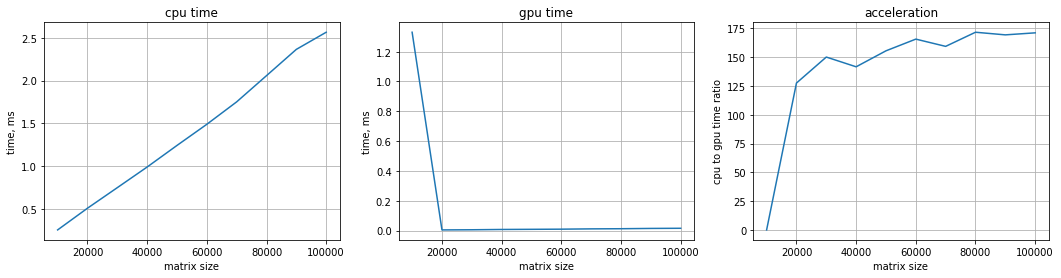

In [ ]:
test()